Source: https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

In [1]:
import os
import pydicom
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pathlib import Path
from ipywidgets import interact, interactive
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize

/home/joshy/anaconda3/envs/jupyter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
data_path = '../data/anonymous_sid10113/'
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [5]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.500000
Pixel Spacing (row, col): (0.791016, 0.791016) 


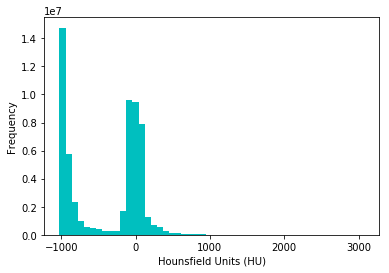

In [6]:
plt.hist(imgs.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

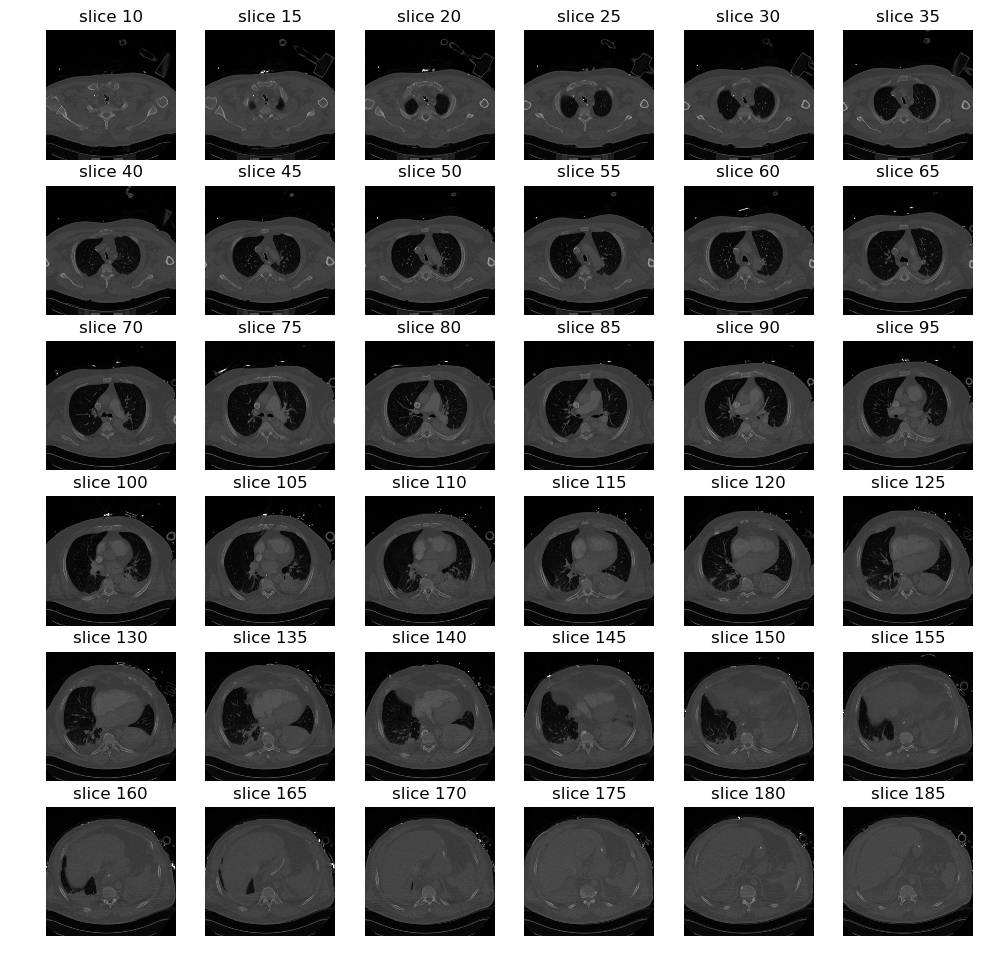

In [7]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12],dpi=100)
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs)

In [8]:
imgs.shape, "<br>", imgs[0], "<br>", type(imgs[0])

((221, 512, 512),
 '<br>',
 array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16),
 '<br>',
 numpy.ndarray)

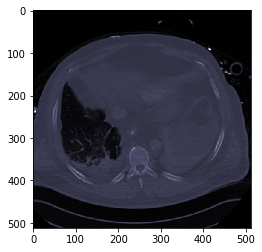

In [9]:
plt.imshow(imgs[150],cmap="bone")

In [37]:
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    orig_img = img.copy()
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([1,1])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='bone')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='bone')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='bone')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='bone')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='bone')
        ax[2, 1].axis('off')
        
        plt.show()
    # change to original implementation, 
    # we want hu field values back in the returned images
    return mask*orig_img

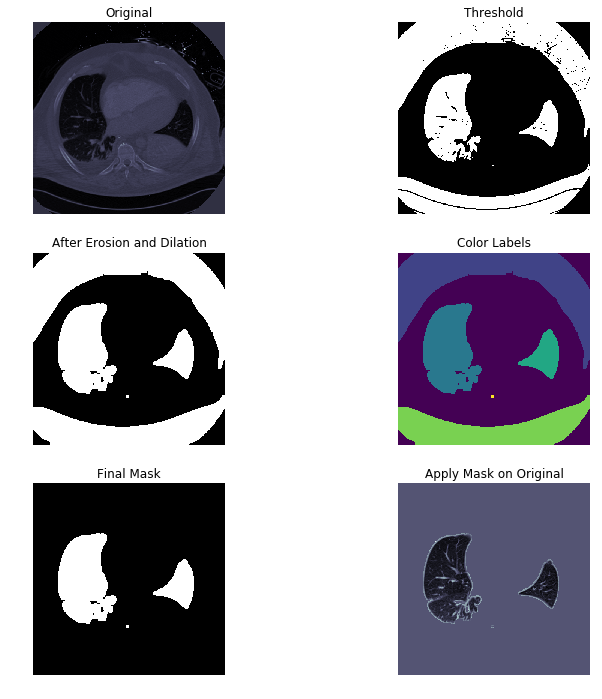

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
a = imgs[130].copy()
make_lungmask(a, display=True)

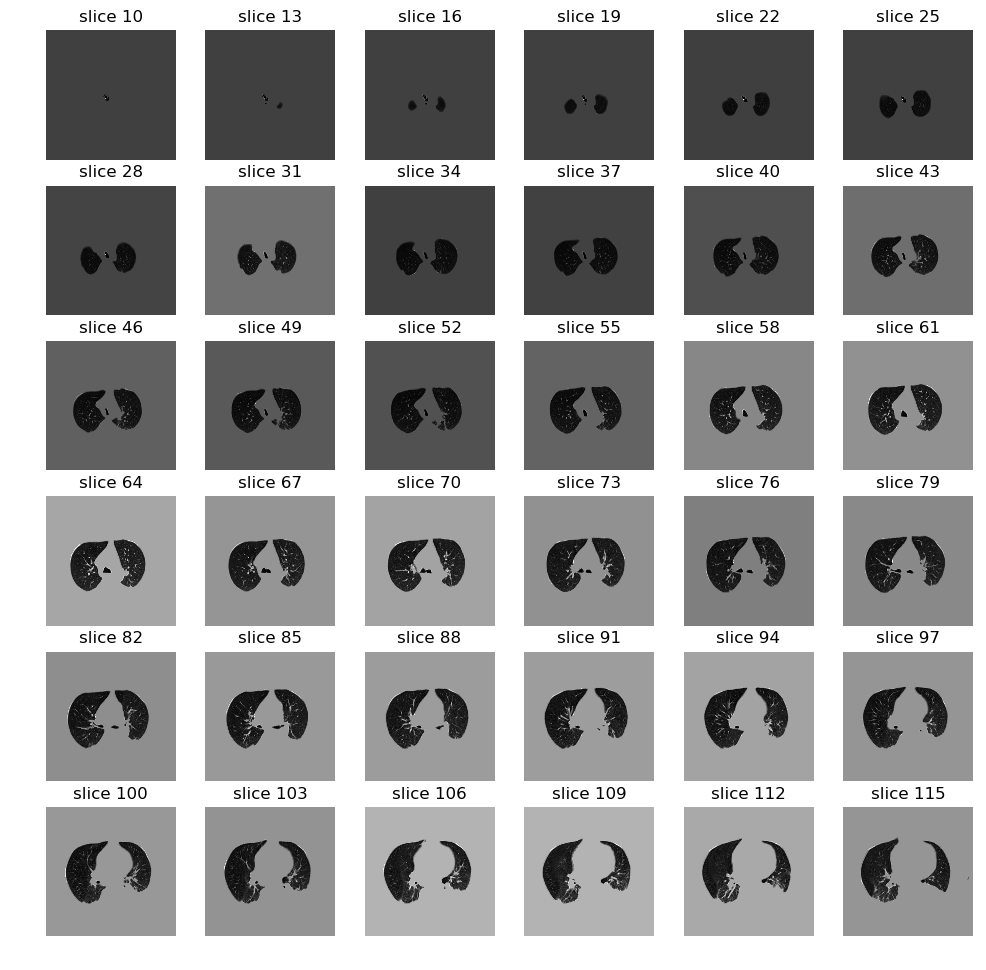

In [34]:
masked_lung = []

for img in imgs:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=3)

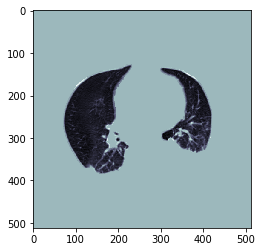

In [39]:
plt.imshow(masked_lung[109], cmap='bone')

In [45]:
MAX_HU_LUNG= -380
MIN_HU_LUNG= -1500
lung_voxels = sum([np.count_nonzero(i*((i >= MIN_HU_LUNG) & (i <= MAX_HU_LUNG))) for i in masked_lung])
print('Lung voxel count is: {}'.format(lung_voxels))

Lung voxel count is 3930299


In [46]:
x, y, z = patient[0].PixelSpacing[0], patient[0].PixelSpacing[1], patient[0].SliceThickness
voxel_volume = x * y * z
print('Voxel volume is {}'.format(voxel_volume))

Voxel volume is 0.9385585784912109


In [47]:
lung_volume = lung_voxels * voxel_volume
volume = round(lung_volume/1000.0)/1000.0
print('Lung volume is {}L'.format(volume))

Lung volume is 3.689L
